In [2]:
import os
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import pandas as pd
import random

data_path = "data" + os.sep
image_folders = [ data_path + "invasive_256x256" + os.sep + "output", data_path + "noninvasive_256x256" + os.sep + "output"]
dataset_name_invas = data_path + "dataset_invas.csv"
dataset_name_noninvas = data_path + "dataset_noninvas.csv"
dataset_name_test = data_path + "dataset_test.csv"
dataset_name_train = data_path + "dataset_train.csv"

image_bw = False

if not os.path.exists(dataset_name_test) and not os.path.exists(dataset_name_train):

    print("Converting data at " + data_path + "...")

    count = 0
    data_train = []
    data_test = []
    for folder in image_folders:
        data = []
        for file_name in os.listdir(folder):
            file_path = os.path.join(folder, file_name)
            # Check if it's an image file (common extensions)
            if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                if "noninvasive" in file_path:
                    row = [ file_path, 0]
                else:
                    row = [ file_path, 1]
                data.append(row)
                count += 1

        random.shuffle(data)
        chunk_size = int(len(data) * 0.8)
        data_train = data_train + data[0:chunk_size]
        data_test = data_test + data[chunk_size:]

    random.shuffle(data_train)
    random.shuffle(data_test)

    print("Preparing train...")
    data = []
    count = 0
    dot_cnt = 0
    for item in data_train:
        row = [ item[0], item[1] ]
        data.append(row)
        count += 1
        if count % 1000 == 0:
            print(".", end="")
            dot_cnt += 1
            if dot_cnt >= 20:
                print("")
                dot_cnt = 0

                print("Create dataframe...")
                df = pd.DataFrame(data)
                print("Write data set train...")
                if os.path.isfile(dataset_name_train):
                    df.to_csv(dataset_name_train, mode="a", index = False, header = False)
                else:
                    df.to_csv(dataset_name_train, index = False, header = True)
                del df
                data = []

    if len(data) > 0:
        print("")
        print("Create dataframe...")
        df = pd.DataFrame(data)
        print("Write data set train...")
        if os.path.isfile(dataset_name_train):
            df.to_csv(dataset_name_train, mode="a", index = False, header = False)
        else:
            df.to_csv(dataset_name_train, index = False, header = True)
        del df

    print("")
    print("Preparing test...")
    data = []
    dot_cnt = 0
    for item in data_test:
        row = [ item[0], item[1] ]
        data.append(row)
        count += 1
        if count % 1000 == 0:
            print(".", end="")
            dot_cnt += 1
            if dot_cnt >= 20:
                print("")
                dot_cnt = 0

                print("Write data set test...")
                df = pd.DataFrame(data)
                if os.path.isfile(dataset_name_test):
                    df.to_csv(dataset_name_test, mode="a", index = False, header = False)
                else:
                    df.to_csv(dataset_name_test, index = False, header = True)
                del df
                data = []

    if len(data) > 0:
        print("")
        print("Write data set test...")
        df = pd.DataFrame(data)
        if os.path.isfile(dataset_name_test):
            df.to_csv(dataset_name_test, mode="a", index = False, header = False)
        else:
            df.to_csv(dataset_name_test, index = False, header = True)
        del df

    print("Total data set: " + str(count))

else:

    print("Using data from " + dataset_name_train)
    print("Using data from " + dataset_name_test)


Using data from data\dataset_train.csv
Using data from data\dataset_test.csv


In [3]:
from torch.utils.data import DataLoader
from torchvision.transforms.functional import pil_to_tensor
from sklearn import preprocessing

class CustomImageDataset(DataLoader):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        label = self.img_labels.iloc[idx, 1]
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        img = Image.open(img_path)
        width, height = img.size
        if width != 256 or height != 256:
            img = img.resize((256, 256))
        if image_bw:
            img.convert("L")
        image = np.array(img).flatten()
        # image = pil_to_tensor(img)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# Load training data
print("Loading train data from " + dataset_name_train)
batch_size = 64
training_data = CustomImageDataset(dataset_name_train, "", None)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle = False)

print("Loading test data from " + dataset_name_test)
testing_data = CustomImageDataset(dataset_name_test, "", None)
testing_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle = False)


Loading train data from data\dataset_train.csv
Loading test data from data\dataset_test.csv


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from datetime import datetime
from sklearn.preprocessing import Normalizer

alg = "SGDC"
print("Training with " + alg + "...")

# Initialize  classifier
# clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
# clf = SGDClassifier(loss='log_loss', random_state=42, warm_start=True)
# clf = SGDClassifier(loss='log_loss', penalty='l2', alpha=0.0001, max_iter=1000, random_state=42)
clf = SGDClassifier(loss='log_loss', penalty='l2', alpha=0.0001, max_iter=1000)

normalizer = Normalizer(norm='l2')

max_train = 0

count = 0
print(str(count).rjust(10), end="")
ts = datetime.now()
first = True
print_stride = 1000
next_print = print_stride
dot_cnt = 0

for i, (images, labels) in enumerate(train_dataloader):
    images_normalized = normalizer.fit_transform(images)   
    clf.partial_fit(images_normalized, labels, classes=np.array([0, 1]))

    count += len(labels)
    if count >= next_print:
        next_print += print_stride
        print(".", end="")
        dot_cnt += 1
        if dot_cnt > 20:
            dot_cnt = 0
            elapsed = datetime.now() - ts
            print(f"{elapsed}")
            print(str(count).rjust(10), end="")

    if max_train > 0 and count >= max_train:
        break

delta = datetime.now() - ts
print("")
print("Time: " + str(delta.seconds) + "." + str(delta.microseconds) + " seconds", flush=True)
print("Model trained with " + str(count))

Training with SGDC...
         0.....................0:00:37.261919
     21056.....................0:01:13.746557
     42048.....................0:01:50.174283
     63040.....................0:02:27.119370
     84032.....................0:03:04.247695
    105024.....................0:03:41.061003
    126016.....................0:04:18.199520
    147008.............
Time: 281.247476 seconds
Model trained with 160000


In [ ]:
import numpy as np

importance = np.abs(clf.coef_[0])  # Absolute values of coefficients
# feature_names = X_train.columns
sorted_idx = np.argsort(importance)[::-1]  # Sort in descending order

for idx in sorted_idx[:10]:  # Top 10 important features
    print(f"{idx}: {importance[idx]}")

In [ ]:
import pandas as pd

data1 = []

for idx in sorted_idx[:]:
    row = [ idx, importance[idx] ]
    data1.append(row)

df = pd.DataFrame(data1)
df.to_csv("test-data1.csv")



In [ ]:
import pandas as pd

data_csv = pd.read_csv("sgdc-important-data.csv")
data_csv = data_csv.drop(data_csv.columns[0], axis=1)
# data_csv = data_csv.head(2000)
print(data_csv)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

w = 256
h = 256
data_rgb = [[0 for x in range(w)] for y in range(h)]

for index, row in data_csv.iterrows():
    idx = int(row[0])
    val = row[1]
    col = (idx % (256 * 3)) // 3
    row = idx // (256 * 3)
    if val > data_rgb[row][col]:
        data_rgb[row][col] = val

df_rgb = pd.DataFrame(data_rgb)
print(df_rgb)


In [ ]:
tickloop = range(0, 255, 16)
ticks = []
ticklabels = []
for label in tickloop:
    ticks.append(label)
    ticklabels.append(str(label))

plt.figure(figsize=(20, 20), dpi=72)  # width = 8 inches, height = 6 inches
hm = sns.heatmap(df_rgb, annot=False, cmap="Reds")
hm.set_xticks(ticks)
hm.set_xticklabels(ticklabels) 
hm.set_yticks(ticks)
hm.set_yticklabels(ticklabels) 
plt.title('SGDC Heat Map')
plt.xlabel('X-Pixel')
plt.ylabel('Y-Pixel')
plt.show()


In [5]:
correct = 0
total = 0
targets = []
preds = []

max_test = 0

print("Testing with " + alg + "...")

print(str(total).rjust(10), end="")
ts = datetime.now()
first = True
next_print = print_stride
dot_cnt = 0
for i, (images, labels) in enumerate(testing_dataloader):
    total += len(labels)
    targets = targets + labels.tolist()
    
    images_normalized = normalizer.transform(images)
    pred = clf.predict(images_normalized)
    correct += (pred == labels).sum().item()
    preds = preds + pred.tolist()

    if total >= next_print:
        next_print += print_stride
        print(".", end="")
        dot_cnt += 1
        if dot_cnt >= 20:
            dot_cnt = 0
            elapsed = datetime.now() - ts
            print(f"{elapsed}")
            print(str(total).rjust(10), end="")
    
    if max_test > 0 and total >= max_test:
        break

delta = datetime.now() - ts
print("")
print("Time: " + str(delta.seconds) + "." + str(delta.microseconds) + " seconds", flush=True)
print("Model test with " + str(total))

print('Accuracy of the mode: {} %'.format(100 * correct / total))

Testing with SGDC...
         0....................0:00:50.436376
     20032....................0:01:40.508347
     40000
Time: 100.508347 seconds
Model test with 40000
Accuracy of the mode: 95.2825 %


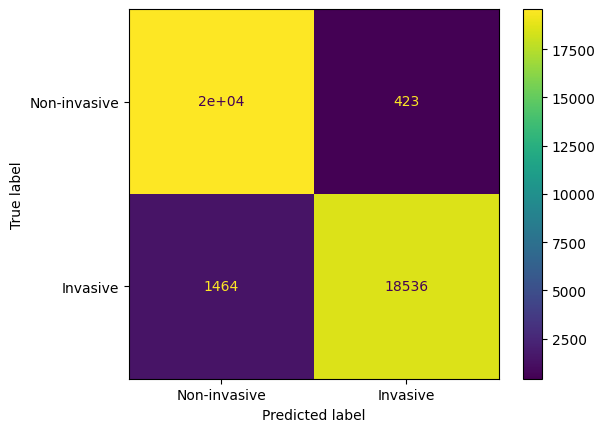

Accuracy: 0.952825 
F1 score: 0.9515644652070125
Recall: 0.9268
Precision: 0.9776886966612163


In [6]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = targets
predicted = preds

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Non-invasive", "Invasive"])

cm_display.plot()
plt.show()

print('Accuracy: {} '.format(metrics.accuracy_score(actual, predicted)))
print('F1 score: {}'.format(metrics.f1_score(actual, predicted)))
print('Recall: {}'.format(metrics.recall_score(actual, predicted)))
print('Precision: {}'.format(metrics.precision_score(actual, predicted)))

````
Training with SGDC...
         0.....................0:00:22.642323
     21056.....................0:00:45.014974
     42048.....................0:01:08.868078
     63040.....................0:01:38.886560
     84032.....................0:02:08.782445
    105024.....................0:02:38.567782
    126016.....................0:03:08.428409
    147008.............
Time: 206.818617 seconds
Model trained with 160000

Testing with SGDC...
         0....................0:00:17.209200
     20032....................0:00:34.780118
     40000
Time: 34.780118 seconds
Model test with 40000
Accuracy of the mode: 94.2 %

Accuracy: 0.942 
F1 score: 0.9436701791871024
Recall: 0.97165
Precision: 0.9172566789389219
````

````
Run #2:

Training with SGDC...
         0.....................0:00:24.846794
     21056.....................0:00:53.652790
     42048.....................0:01:25.345166
     63040.....................0:01:56.615194
     84032.....................0:02:27.677658
    105024.....................0:02:58.738351
    126016.....................0:03:30.027545
    147008.............
Time: 229.354371 seconds
Model trained with 160000

Importance:

97922: 2548.463033931907
97919: 2443.08970863177
109820: 2113.2118833036384
98690: 2031.8138621979235
98687: 1989.4222945484246
105576: 1986.5961900384646
102518: 1976.0060621494918
101750: 1953.8320113789723
82622: 1947.186007366531
94862: 1931.9685215436325

Testing with SGDC...
         0....................0:00:26.238149
     20032....................0:00:52.395708
     40000
Time: 52.395708 seconds
Model test with 40000
Accuracy of the mode: 94.2 %

Accuracy: 0.942 
F1 score: 0.9436701791871024
Recall: 0.97165
Precision: 0.9172566789389219

````


````
Run #1
Accuracy: 0.942 
F1 score: 0.9436701791871024
Recall: 0.97165
Precision: 0.9172566789389219

Run #2
Accuracy: 0.949775 
F1 score: 0.9508188694949693
Recall: 0.971
Precision: 0.9314595424240971

Run #3
Accuracy: 0.92615 
F1 score: 0.9217732111646629
Recall: 0.8702
Precision: 0.9798446120932327

Run #4
Accuracy: 0.7365 
F1 score: 0.6477743617163481
Recall: 0.4846
Precision: 0.9766223297057638

Run #5
Accuracy: 0.646825 
F1 score: 0.4628721341393863
Recall: 0.30435
Precision: 0.9660371369623869

Run #6:
Accuracy: 0.5563 
F1 score: 0.6923236946120241
Recall: 0.9984
Precision: 0.529880055195839

Run #7 seeded:
Accuracy: 0.942 
F1 score: 0.9436701791871024
Recall: 0.97165
Precision: 0.9172566789389219

Run #8:
Accuracy: 0.947325 
F1 score: 0.9484324139112558
Recall: 0.9688
Precision: 0.9289035907761638

Run #9:
Accuracy: 0.9525 
F1 score: 0.9533444651802377
Recall: 0.9706
Precision: 0.9366917583478093

Run #10:
Accuracy: 0.904925 
F1 score: 0.8966997147901671
Recall: 0.8253
Precision: 0.9816235504014273

Run #11:
Accuracy: 0.772325 
F1 score: 0.709958915889041
Recall: 0.5573
Precision: 0.9778050706202298

Run #12:
Accuracy: 0.956125 
F1 score: 0.9564505322712722
Recall: 0.9636
Precision: 0.949406374698261

````

```

Run 1A:
Accuracy: 0.727475 
F1 score: 0.7849604481881127
Recall: 0.9948
Precision: 0.6482259798651159

Run 2A:
Accuracy: 0.95175 
F1 score: 0.9505913675695049
Recall: 0.9283
Precision: 0.9739796453677474

Run 3A:
Accuracy: 0.947775 
F1 score: 0.9461861459594528
Recall: 0.91825
Precision: 0.9758754450289601

Run 4A:
Accuracy: 0.9589 
F1 score: 0.9586394283989131
Recall: 0.9526
Precision: 0.9647559246505976

Run 5A:
Accuracy: 0.85655 
F1 score: 0.8728561932195879
Recall: 0.9848
Precision: 0.7837644249900517

Run 6A:
Accuracy: 0.958 
F1 score: 0.9573235787227556
Recall: 0.94215
Precision: 0.9729939068470516

Run 7A:
Accuracy: 0.892775 
F1 score: 0.8819140442168443
Recall: 0.8008
Precision: 0.9813124195821334

Run 8A:
Accuracy: 0.959975 
F1 score: 0.9597950829964089
Recall: 0.9555
Precision: 0.9641289541395489

Run 9A:
Accuracy: 0.503025 
F1 score: 0.6678585153130273
Recall: 0.9993
Precision: 0.5015181551278513

Run 10A:
Accuracy: 0.692525 
F1 score: 0.5627644068399161
Recall: 0.39575
Precision: 0.9736744987083282

```

````
Re-run with L2 normalized on 8/15/2025

Training with SGDC...
         0.....................0:00:37.261919
     21056.....................0:01:13.746557
     42048.....................0:01:50.174283
     63040.....................0:02:27.119370
     84032.....................0:03:04.247695
    105024.....................0:03:41.061003
    126016.....................0:04:18.199520
    147008.............
Time: 281.247476 seconds
Model trained with 160000

Testing with SGDC...
         0....................0:00:50.436376
     20032....................0:01:40.508347
     40000
Time: 100.508347 seconds
Model test with 40000
Accuracy of the mode: 95.2825 %

````

In [ ]:

# Example accuracy scores for three models
model1_accuracies = [0.9436701791871024, 0.9484324139112558, 0.9533444651802377, 0.8966997147901671, 0.709958915889041]
model2_accuracies = [0.78, 0.80, 0.79, 0.81, 0.77]
model3_accuracies = [0.90, 0.92, 0.91, 0.89, 0.93]

# Perform one-way ANOVA
f_stat, p_value = stats.f_oneway(model1_accuracies, model2_accuracies, model3_accuracies)

print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between the models' accuracies.")
else:
    print("No significant difference between the models' accuracies.")